In [23]:
import os
import random
import kagglehub
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='PIL')

seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

In [3]:
print(f"contents in the file: ",os.listdir(path))

contents in the file:  ['README.dataset.txt', 'Bone_Fracture_Binary_Classification']


In [4]:
data_path = os.path.join(path, "Bone_Fracture_Binary_Classification", "Bone_Fracture_Binary_Classification")
print(f"folders in the data_path: ",os.listdir(data_path))

folders in the data_path:  ['val', 'test', 'train']


In [5]:
from PIL import Image
import os

def check_image_types(data_dir):
    """Check if images are grayscale or RGB"""
    grayscale_count = 0
    rgb_count = 0
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    if img.mode == 'L':  # Grayscale
                        grayscale_count += 1
                    elif img.mode == 'RGB':
                        rgb_count += 1
                    else:
                        print(f"Unusual mode {img.mode}: {img_path}")
                except:
                    pass
    
    print(f"Grayscale images: {grayscale_count}")
    print(f"RGB images: {rgb_count}")
    return grayscale_count, rgb_count

check_image_types(data_path)

Unusual mode P: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/A-pathologic-fracture-through-the-tumour-mass-is-evident-Note-the-deviation-of-the.png
Unusual mode RGBA: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/tibia20path20fx.jpg
Unusual mode P: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/Pre-operative-radiograph-of-a-pathological-fracture-involving-the-proximal-humerus-The.png
Unusual mode RGBA: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/8-2010728x6.png
Unusual mode P: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/Pre-operativeX-ray-showing-patholog

(511, 10041)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class RobustImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform, loader=pil_loader)
    
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (OSError, ValueError) as e:
            print(f"Corrupted image at index {index}: {e}")
            raise IndexError

In [7]:
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")
test_dir  = os.path.join(data_path, "test")

In [8]:
train_dataset = RobustImageFolder(train_dir, transform=transform)
val_dataset   = RobustImageFolder(val_dir, transform=transform)
test_dataset  = RobustImageFolder(test_dir, transform=transform)

In [9]:
print("length of each folder")
print(f"train: {len(train_dataset)}")
print(f"val: {len(val_dataset)}")
print(f"test: {len(test_dataset)}")

length of each folder
train: 9246
val: 829
test: 506


In [10]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

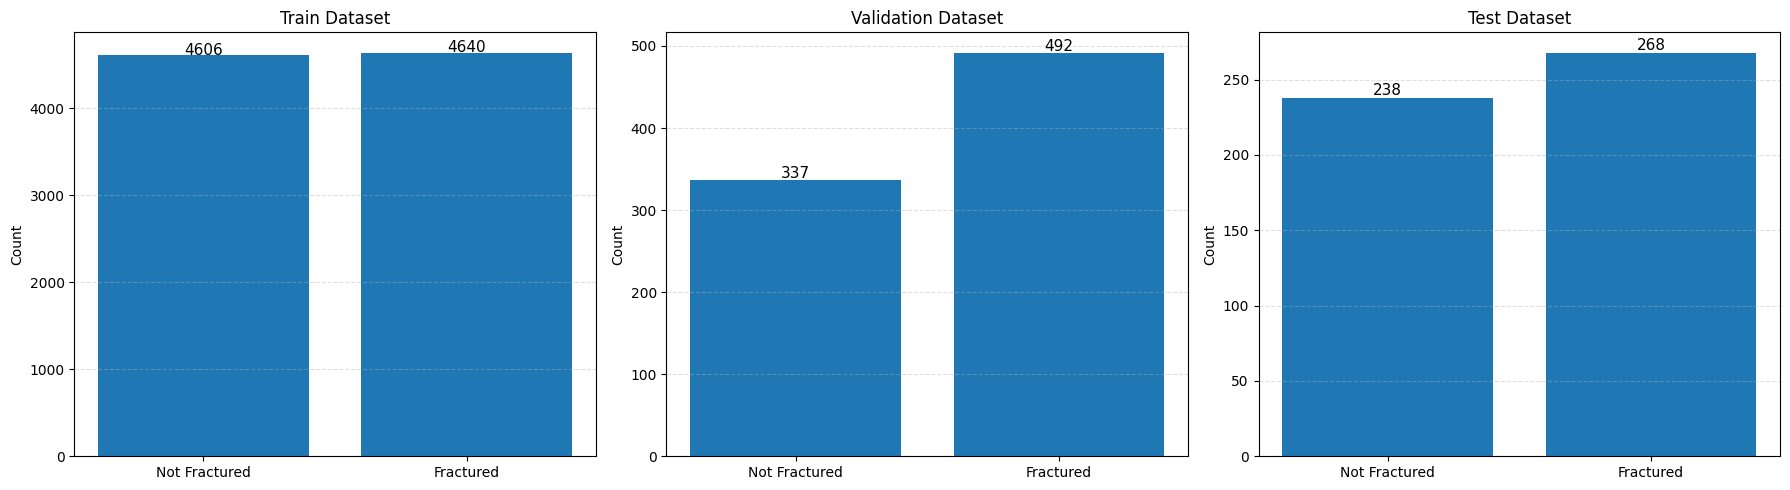

In [47]:
def get_class_counts(dataset):
    labels = [label for _, label in dataset]
    classes, counts = np.unique(labels, return_counts=True)
    return classes, counts

class_names = ["Not Fractured", "Fractured"]

# Get counts
train_classes, train_counts = get_class_counts(train_dataset)
val_classes, val_counts = get_class_counts(val_dataset)
test_classes, test_counts = get_class_counts(test_dataset)

# Plot horizontally
plt.figure(figsize=(18, 5))

datasets = [
    ("Train Dataset", train_classes, train_counts),
    ("Validation Dataset", val_classes, val_counts),
    ("Test Dataset", test_classes, test_counts)
]

for idx, (title, classes, counts) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)
    plt.bar(classes, counts)
    plt.xticks(classes, class_names)
    plt.title(title)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
    for i, count in enumerate(counts):
        plt.text(i, count + 2, str(count), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


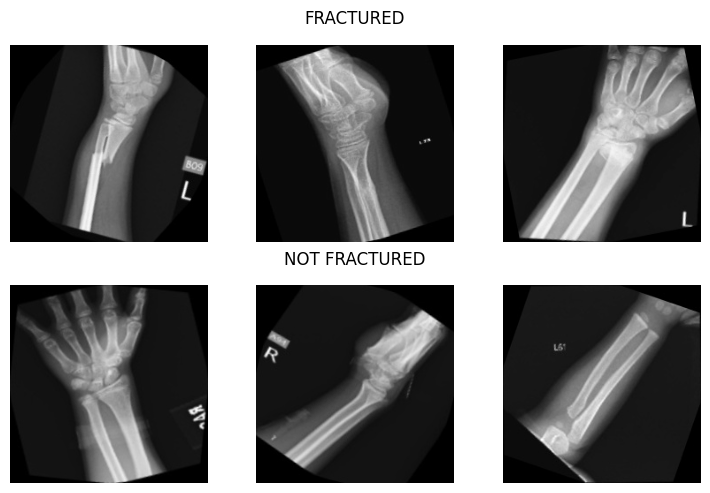

In [53]:
classes = train_dataset.classes  # ['fractured', 'not fractured']

plt.figure(figsize=(10, 5))

for i, cls in enumerate(classes):
    # Get all indices of images belonging to the current class
    indices = [idx for idx, (_, label) in enumerate(train_dataset) if label == i]
    
    # Pick 4 random images from that class
    sample_indices = random.sample(indices, 3)
    
    for j, idx in enumerate(sample_indices):
        img, label = train_dataset[idx]
        
        # Take only the first channel for grayscale
        img = img[0, :, :]  # [H, W]
        
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        
        if j == 1:
            plt.title(cls.upper(), fontsize=12, pad=15)

plt.tight_layout()
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
model = models.regnet_x_400mf(weights=models.RegNet_X_400MF_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features  

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

model = model.to(device)

In [27]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 32, 56, 56]           1,024
       BatchNorm2d-5           [-1, 32, 56, 56]              64
            Conv2d-6         [-1, 32, 112, 112]           1,024
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           1,024
      BatchNorm2d-13           [-1, 32, 56, 56]              64
             ReLU-14           [-1, 32,

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

In [29]:
num_epochs = 20
patience = 3
best_val_acc = 0.0
counter = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.3, patience=2
)

# To store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "learning_rates": []
}

for epoch in range(num_epochs):
    # Get current learning rate at the start of epoch
    current_lr = optimizer.param_groups[0]['lr']
    
    # Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        
        loop.set_postfix(loss=loss.item(), acc=100 * correct_train / total_train)
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    # Validation 
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    
    # Save metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["learning_rates"].append(current_lr)
    
    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.6f}")
    
    # Scheduler step (updates LR for NEXT epoch)
    old_lr = current_lr
    scheduler.step(val_acc)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Print if LR changed
    if new_lr != old_lr:
        print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")
    
    # Early Stopping & Model Saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, "best_model.pth")
        print(f"New best model saved with Val Acc: {val_acc:.2f}%")
    else:
        counter += 1
        if counter >= patience:
            print()
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            print()
            break

print()
print(f"Training completed!")
print(f"Total epochs run: {len(history['train_loss'])}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print()

Epoch [1/20] | Train Loss: 0.5144, Train Acc: 75.76% | Val Loss: 0.3998, Val Acc: 83.96% | LR: 0.000100
New best model saved with Val Acc: 83.96%


Epoch [2/20] | Train Loss: 0.3848, Train Acc: 83.70% | Val Loss: 0.3452, Val Acc: 86.37% | LR: 0.000100
New best model saved with Val Acc: 86.37%


Epoch [3/20] | Train Loss: 0.3280, Train Acc: 86.23% | Val Loss: 0.3095, Val Acc: 87.70% | LR: 0.000100
New best model saved with Val Acc: 87.70%


Epoch [4/20] | Train Loss: 0.2820, Train Acc: 89.20% | Val Loss: 0.2831, Val Acc: 89.26% | LR: 0.000100
New best model saved with Val Acc: 89.26%


Epoch [5/20] | Train Loss: 0.2485, Train Acc: 90.74% | Val Loss: 0.2857, Val Acc: 87.45% | LR: 0.000100


Epoch [6/20] | Train Loss: 0.2220, Train Acc: 92.05% | Val Loss: 0.2357, Val Acc: 90.83% | LR: 0.000100
New best model saved with Val Acc: 90.83%


Epoch [7/20] | Train Loss: 0.1987, Train Acc: 92.83% | Val Loss: 0.2127, Val Acc: 92.64% | LR: 0.000100
New best model saved with Val Acc: 92.64%


Epoch [8/20] | Train Loss: 0.1748, Train Acc: 94.00% | Val Loss: 0.1966, Val Acc: 93.24% | LR: 0.000100
New best model saved with Val Acc: 93.24%


Epoch [9/20] | Train Loss: 0.1519, Train Acc: 95.09% | Val Loss: 0.1874, Val Acc: 93.61% | LR: 0.000100
New best model saved with Val Acc: 93.61%


Epoch [10/20] | Train Loss: 0.1320, Train Acc: 95.85% | Val Loss: 0.1610, Val Acc: 93.37% | LR: 0.000100


Epoch [11/20] | Train Loss: 0.1205, Train Acc: 96.33% | Val Loss: 0.1371, Val Acc: 95.66% | LR: 0.000100
New best model saved with Val Acc: 95.66%


Epoch [12/20] | Train Loss: 0.1016, Train Acc: 97.17% | Val Loss: 0.1408, Val Acc: 95.30% | LR: 0.000100


Epoch [13/20] | Train Loss: 0.0941, Train Acc: 97.49% | Val Loss: 0.1205, Val Acc: 95.90% | LR: 0.000100
New best model saved with Val Acc: 95.90%


Epoch [14/20] | Train Loss: 0.0836, Train Acc: 97.71% | Val Loss: 0.1004, Val Acc: 96.98% | LR: 0.000100
New best model saved with Val Acc: 96.98%


Epoch [15/20] | Train Loss: 0.0779, Train Acc: 98.05% | Val Loss: 0.0959, Val Acc: 96.86% | LR: 0.000100


Epoch [16/20] | Train Loss: 0.0684, Train Acc: 98.17% | Val Loss: 0.0797, Val Acc: 97.83% | LR: 0.000100
New best model saved with Val Acc: 97.83%


Epoch [17/20] | Train Loss: 0.0604, Train Acc: 98.51% | Val Loss: 0.0869, Val Acc: 97.23% | LR: 0.000100


Epoch [18/20] | Train Loss: 0.0561, Train Acc: 98.59% | Val Loss: 0.0813, Val Acc: 97.35% | LR: 0.000100


Epoch [19/20] | Train Loss: 0.0490, Train Acc: 98.92% | Val Loss: 0.0693, Val Acc: 97.95% | LR: 0.000100
New best model saved with Val Acc: 97.95%


Epoch [20/20] | Train Loss: 0.0442, Train Acc: 98.95% | Val Loss: 0.0690, Val Acc: 97.59% | LR: 0.000100

Training completed!
Total epochs run: 20
Best Validation Accuracy: 97.95%



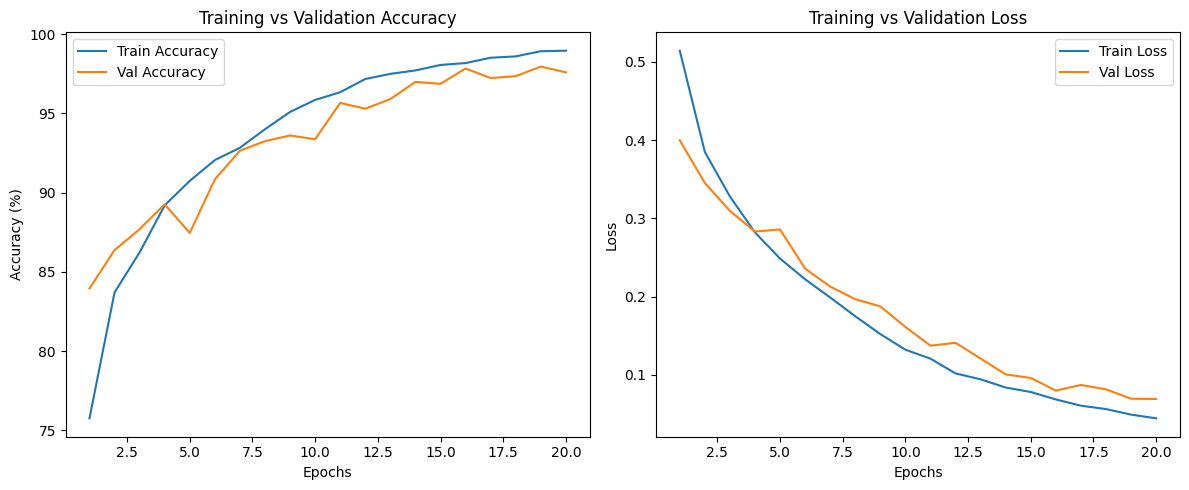

In [30]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(False)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

In [31]:
checkpoint = torch.load("best_model.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

all_preds = []
all_labels = []
all_probs = [] 
correct = 0
total = 0
test_loss = 0.0
criterion = nn.CrossEntropyLoss()


In [32]:
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Get probabilities using softmax for ROC and predictions
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        
        # Update accuracy counters
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Collect results for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # store probability of the fractured class
        all_probs.extend(probs[:, 0].cpu().numpy())

Testing: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


In [33]:
# Calculate average test loss
test_loss = test_loss / len(test_loader)

# Calculate Test Accuracy
test_accuracy = 100 * correct / total

print("Test Performance Summary")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Performance Summary
Test Accuracy: 96.84%
Test Loss: 0.0955


<Figure size 800x800 with 0 Axes>

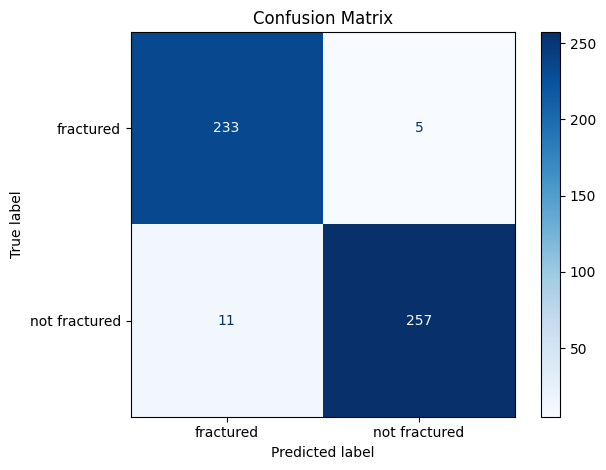

In [34]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=train_dataset.classes
)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [35]:
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


--- Classification Report ---
               precision    recall  f1-score   support

    fractured       0.95      0.98      0.97       238
not fractured       0.98      0.96      0.97       268

     accuracy                           0.97       506
    macro avg       0.97      0.97      0.97       506
 weighted avg       0.97      0.97      0.97       506



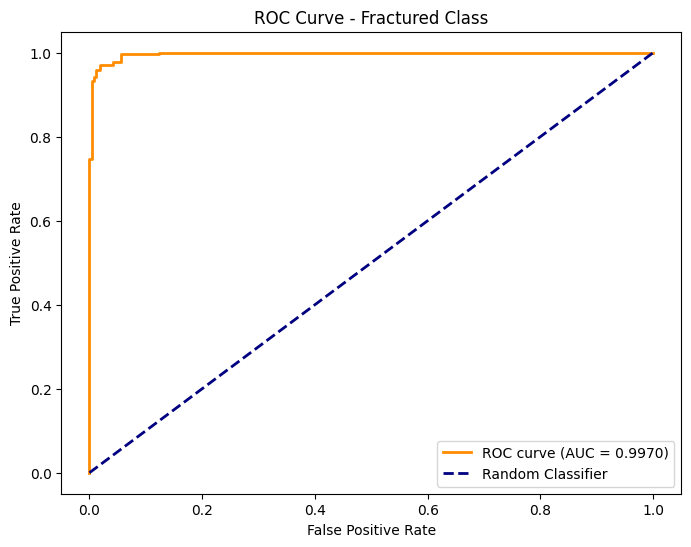

In [36]:
# Convert to numpy
all_probs = np.array(all_probs)

# Calculate ROC curve (fractured is positive class)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fractured Class')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()
